<a href="https://colab.research.google.com/github/Fauzi-Taufiq/Proyek-Data-Mining/blob/main/Face_Mask_detector_3_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras import models, layers, Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet, MobileNetV2, EfficientNetB0, NASNetMobile
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, CSVLogger,ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import cv2
import random

# Bagian Baru

# Bagian Baru

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"theopilusbayu27","key":"5540ccd3b5cdf2e6976a8c91dc369ab0"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-01 11:18:46           6911  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4128  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1382  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           2140  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

In [ ]:
!kaggle datasets download -d vijaykumar1799/face-mask-detection
!ls

 94% 208M/222M [00:02<00:00, 113MB/s]
100% 222M/222M [00:02<00:00, 91.5MB/s]
face-mask-detection.zip  kaggle.json  sample_data


In [ ]:
!unzip face-mask-detection.zip -d FaceMask_Dataset


Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: FaceMask_Dataset/Dataset/with_mask/1890.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1891.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1892.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1893.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1894.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1895.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1896.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1897.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1898.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1899.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/19.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/190.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1900.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1901.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1902.png  
  inflating: FaceMask_Dataset/Dataset/with_mask/1903.png  


### Data is available at: https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

NOTE: I have created a folder 'Test' and put a mixure of with mask and without mask images. In original dataset these images are placed under separate folders.

In [ ]:
sdir="FaceMask_Dataset/Dataset"
filepaths=[]
labels=[]
class_list=os.listdir(sdir)
for klass in class_list:
    classpath=os.path.join(sdir, klass)
    flist=os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        if klass=='mask_weared_incorrect':
            nclass='incorrect'
        elif klass=='without_mask':
            nclass='no mask'
        else:
            nclass='mask'
        labels.append(nclass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)

print('df length: ', len(df))
balance=df['labels'].value_counts()
print (balance)

df length:  8982
no mask      2994
incorrect    2994
mask         2994
Name: labels, dtype: int64


In [ ]:
train_split=.9
valid_split=.05

dummy_split=valid_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split,
                                    shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dummy_split,
                                   shuffle=True, random_state=123)
print('train_df length: ', len(train_df), '  test_df length: ',
      len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  8083   test_df length:  450   valid_df length:  449


In [ ]:
height=42
width=42
channels=3
batch_size=64
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  75   test steps:  6


In [ ]:
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
train_datagen=ImageDataGenerator(rescale=1./255,)
val_datagen = ImageDataGenerator(rescale=1./255,)

train_gen=train_datagen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    shuffle=True, batch_size=batch_size)
test_gen=val_datagen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                    shuffle=False, batch_size=test_batch_size)
valid_gen=val_datagen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

Found 8083 validated image filenames belonging to 3 classes.
Found 450 validated image filenames belonging to 3 classes.
Found 449 validated image filenames belonging to 3 classes.
['incorrect', 'mask', 'no mask']


In [ ]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

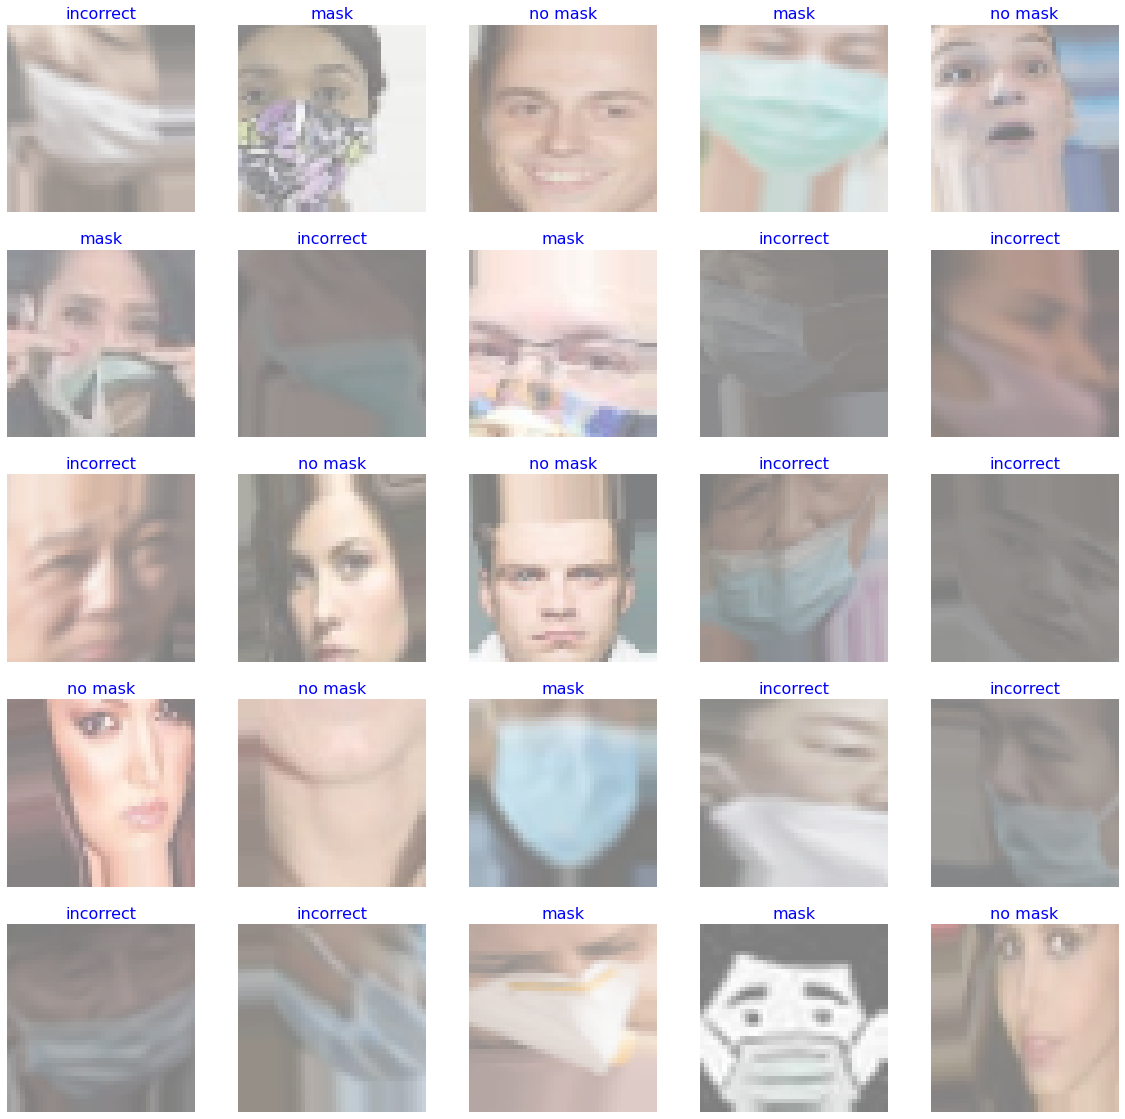

In [ ]:
show_image_samples(train_gen)

In [ ]:
def cvgg_7():

    model = Sequential()

    # Block - 1
    model.add(Conv2D(64, 3, padding='same', input_shape=img_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2, 2, padding='same'))

    # Block - 2
    model.add(Conv2D(64, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2, 2, padding='same'))

    # Block - 3
    model.add(Conv2D(128, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2, 2, padding='same'))

    # Block - 4
    model.add(Conv2D(256, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2, 2, padding='same'))

    model.add(Flatten())  # flattening

    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))  # hidden layer - 1
    model.add(Dense(256, activation='relu')) # hidden layer - 2

    model.add(Dense(class_count, activation='softmax')) # classifier

    return model

CVGG = cvgg_7()
CVGG.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 42, 42, 64)        1792      
_________________________________________________________________
batch_normalization_15 (Batc (None, 42, 42, 64)        256       
_________________________________________________________________
activation_391 (Activation)  (None, 42, 42, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
batch_normalization_16 (Batc (None, 21, 21, 64)        256       
_________________________________________________________________
activation_392 (Activation)  (None, 21, 21, 64)      

In [ ]:
def mobilenet():

  base_model = Sequential()
  inputs = Input((width,height, 3))
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=img_shape)
  model = models.Sequential()
  model.add(base_model)
  x = base_model(inputs)
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, activation='relu')(x)
  predictions = Dense(class_count, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  return model

CVCNNMobileNet = mobilenet()
CVCNNMobileNet.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 42, 42, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 21, 21, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 21, 21, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 21, 21, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 21, 21, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 21, 21, 32)        128       
______________________________________________________________

In [ ]:
def mobilenetv2():

  base_model = Sequential()
  inputs = Input((width,height, 3))
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_shape)
  x = base_model(inputs)
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, activation='relu')(x)
  predictions = Dense(class_count, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  # model.summary()
  return model

CVCNNMobileNet2 = mobilenetv2()
CVCNNMobileNet2.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 42, 42, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 21, 21, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 21, 21, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 21, 21, 32)   0           bn_Conv1[0][0]                   
_____________________________

In [ ]:
def efficientnetb0():

  base_model = Sequential()
  inputs = Input((width,height, 3))
  base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_shape)
  x = base_model(inputs)
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, activation='relu')(x)
  predictions = Dense(class_count, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  # model.summary()
  return model

CVCNNEfficientNet = efficientnetb0()
CVCNNEfficientNet.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42, 42, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 42, 42, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 42, 42, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 43, 43, 3)    0           normalization[0][0]              
___________________________

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def nasnetmobile():

  base_model = Sequential()
  inputs = Input((width,height, 3))
  base_model = NASNetMobile(weights=None, input_shape=img_shape,include_top=False)
  # base_model.load_weights('/content/drive/MyDrive/Project Penelitian RISTEK/model/NASNet-mobile-no-top.h5')
  x = base_model(inputs)
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, activation='relu')(x)
  predictions = Dense(class_count, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  # model.summary()
  return model

CVCNNNasNet = nasnetmobile()
CVCNNNasNet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 42, 42, 3)]  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 20, 20, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 20, 20, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 20, 20, 32)   0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [ ]:
filepath_acc='/content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/new2/best_acc_weights.hdf5'
filepath_loss='/content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/new2/best_loss_weights.hdf5'

# model checkpoint untuk menyimpan best acc/loss model
checkpoint_loss = ModelCheckpoint(filepath_loss, verbose=1, monitor='val_loss', save_best_only=True, mode='min')
checkpoint_acc = ModelCheckpoint(filepath_acc, verbose=1, monitor='val_accuracy', save_best_only=True, mode='max')

# early stop train apabila val loss bertambah
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

# mengurangi lr apabila val acc tidak bertambah
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=2, verbose=1)

# list callback
callbacks_list = [checkpoint_loss, checkpoint_acc, lr_reduce]

In [ ]:
# init model

cvModels = {'CVGG7': cvgg_7(), 'NasNetMobile': nasnetmobile(), 'MobileNet': mobilenet(), 'MobileNetV2': mobilenetv2(), 'EfficientNetB0': efficientnetb0()}
cvModels

{'CVGG7': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f7e1c844f10>,
 'EfficientNetB0': <tensorflow.python.keras.engine.functional.Functional at 0x7f7e1ba43f90>,
 'MobileNet': <tensorflow.python.keras.engine.functional.Functional at 0x7f7e1aa376d0>,
 'MobileNetV2': <tensorflow.python.keras.engine.functional.Functional at 0x7f7e1f123f90>,
 'NasNetMobile': <tensorflow.python.keras.engine.functional.Functional at 0x7f7e1b981550>}

In [ ]:
# train all model dimulai!

%%time
allModels = []

for models in cvModels:
  print('\n')
  print(models)
  modelsTrain = cvModels[models]

  adam = Adam(lr=0.01)

  modelsTrain.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  filepath_acc='/content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/best model2/' + models + '-best_acc_weights-{epoch:03d}.hdf5'
  filepath_loss='/content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/best model2/' + models + '-best_loss_weights-{epoch:03d}.hdf5'

  # model checkpoint untuk menyimpan best acc/loss model
  checkpoint_loss = ModelCheckpoint(filepath_loss, verbose=1, monitor='val_loss', save_best_only=True, mode='min')
  checkpoint_acc = ModelCheckpoint(filepath_acc, verbose=1, monitor='val_accuracy', save_best_only=True, mode='max')

  # mengurangi lr apabila val acc tidak bertambah
  lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=2, verbose=1)

  # list callback
  callbacks_list = [checkpoint_loss, checkpoint_acc, lr_reduce]

  epoch = 25

  #steps_per_epoch = train_gen.n//train_gen.batch_size
  #validation_steps = val_gen.n//val_gen.batch_size

  allModels.append(modelsTrain.fit(
        x=train_gen,  epochs=epoch, callbacks=callbacks_list,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False, verbose=1
    )
  )



CVGG7
Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


127/127 [==============================] - 12s 93ms/step - loss: 1.7426 - accuracy: 0.6730 - val_loss: 0.8201 - val_accuracy: 0.7016

Epoch 00001: val_loss improved from inf to 0.82013, saving model to /content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/best model2/CVGG7-best_loss_weights-001.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.70156, saving model to /content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/best model2/CVGG7-best_acc_weights-001.hdf5
Epoch 2/25
127/127 [==============================] - 12s 93ms/step - loss: 0.5330 - accuracy: 0.7903 - val_loss: 0.5456 - val_accuracy: 0.7996

Epoch 00002: val_loss improved from 0.82013 to 0.54562, saving model to /content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/best model2/CVGG7-best_loss_weights-002.hdf5

Epoch 00002: val_accuracy improved from 0.70156 to 0.79955, saving model to /content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/best model2/CVGG7-best_acc_w

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Epoch 00001: val_accuracy improved from -inf to 0.30958, saving model to /content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/best model2/NasNetMobile-best_acc_weights-001.hdf5
Epoch 2/25
127/127 [==============================] - 19s 146ms/step - loss: 0.4824 - accuracy: 0.8321 - val_loss: 172729.7344 - val_accuracy: 0.3096

Epoch 00002: val_loss improved from 3556630.50000 to 172729.73438, saving model to /content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/best model2/NasNetMobile-best_loss_weights-002.hdf5

Epoch 00002: val_accuracy did not improve from 0.30958
Epoch 3/25
127/127 [==============================] - 18s 143ms/step - loss: 0.3968 - accuracy: 0.8593 - val_loss: 25220.2520 - val_accuracy: 0.3096

Epoch 00003: val_loss improved from 172729.73438 to 25220.25195, saving model to /content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/best model2/NasNetMobile-best_loss_weights-003.hdf5

Epoch 00003: val_accuracy did not improve from 0

IndexError: ignored

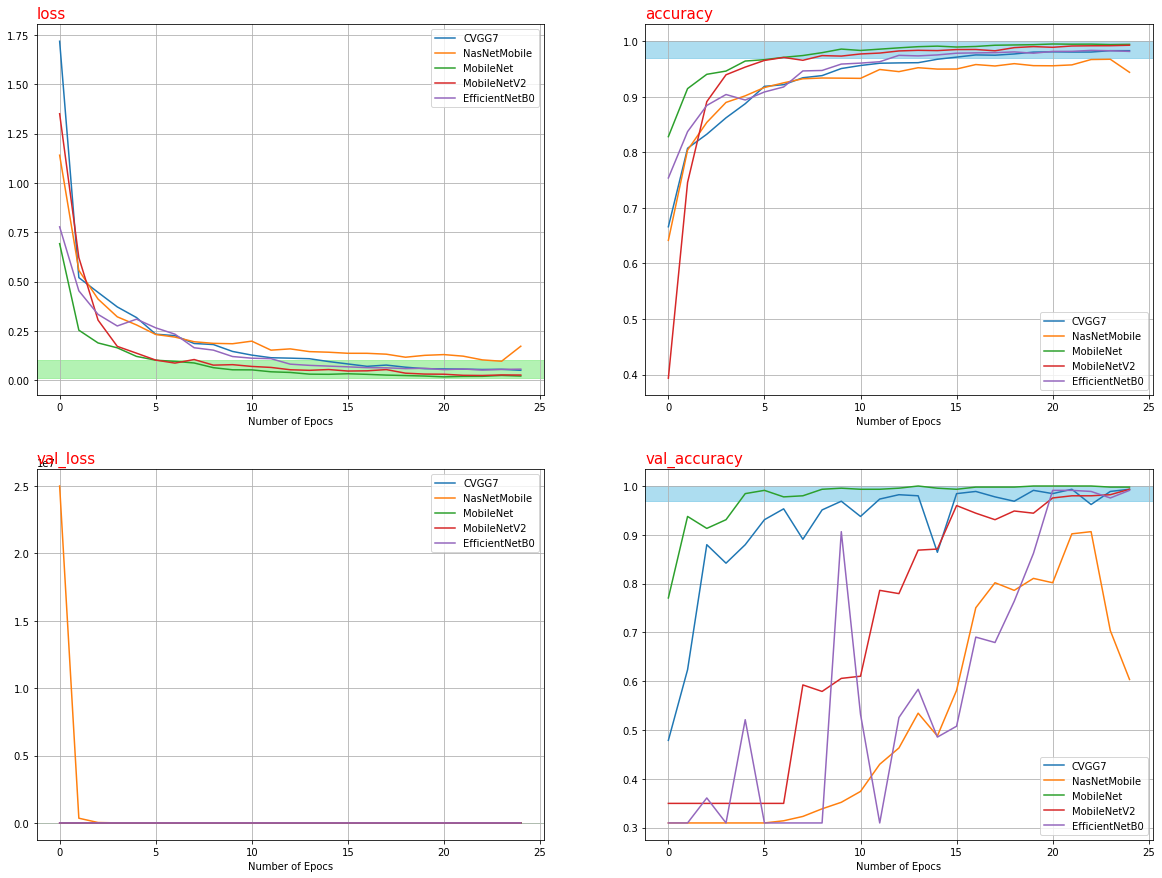

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
for i, value in enumerate(allModels[0].history):
    ax = axes.flatten()[i]
    lab = 0
    for history in allModels:
        label = list(cvModels)[lab]
        ax.plot(history.history[value],label=label)
        if value == "accuracy" or value == "val_accuracy":
            ax.axhspan(0.97,1, color = "skyblue", alpha = 0.2)
        elif value == "loss" or value == "val_loss":
            ax.axhspan(0.1,0.01, color = "lightgreen", alpha = 0.2)
        lab += 1
    ax.set_title(value, size = 15, color = "r", loc= "left")
    ax.legend()
    ax.set_xlabel("Number of Epocs")
    ax.grid()
plt.show()

In [ ]:
for models in cvModels:
  modelTest = cvModels[models]

  test_steps = test_gen.n//test_gen.batch_size

  eval_test = modelTest.evaluate(test_gen)
  print('Model name: ' + models)
  print('Test Loss: ' , '\033[1m', round(eval_test[0]*100, 2),'%\033[0m')
  print('Test Acc: ' , '\033[1m', round(eval_test[1]*100, 2),'%\033[0m')

6/6 [==============================] - 0s 55ms/step - loss: 0.0336 - accuracy: 0.9889
Model name: CVGG7
Test Loss:   3.36 %
Test Acc:   98.89 %
6/6 [==============================] - 0s 67ms/step - loss: 114.6237 - accuracy: 0.6178
Model name: NasNetMobile
Test Loss:   11462.37 %
Test Acc:   61.78 %
6/6 [==============================] - 0s 55ms/step - loss: 0.0193 - accuracy: 0.9933
Model name: MobileNet
Test Loss:   1.93 %
Test Acc:   99.33 %
6/6 [==============================] - 0s 57ms/step - loss: 0.0122 - accuracy: 0.9978
Model name: MobileNetV2
Test Loss:   1.22 %
Test Acc:   99.78 %
6/6 [==============================] - 0s 61ms/step - loss: 0.0506 - accuracy: 0.9889
Model name: EfficientNetB0
Test Loss:   5.06 %
Test Acc:   98.89 %


In [ ]:
for models in cvModels:
  modelTest = cvModels[models]

  test_steps = test_gen.n//test_gen.batch_size

  eval_test = modelTest.evaluate(test_gen)
  print('Model name: ' + models)
  print('Test Loss: ' , '\033[1m', round(eval_test[0]*100, 2),'%\033[0m')
  print('Test Acc: ' , '\033[1m', round(eval_test[1]*100, 2),'%\033[0m')

6/6 [==============================] - 0s 54ms/step - loss: 0.0336 - accuracy: 0.9889
Model name: CVGG7
Test Loss:   3.36 %
Test Acc:   98.89 %
6/6 [==============================] - 0s 68ms/step - loss: 114.6237 - accuracy: 0.6178
Model name: NasNetMobile
Test Loss:   11462.37 %
Test Acc:   61.78 %
6/6 [==============================] - 0s 56ms/step - loss: 0.0193 - accuracy: 0.9933
Model name: MobileNet
Test Loss:   1.93 %
Test Acc:   99.33 %
6/6 [==============================] - 0s 57ms/step - loss: 0.0122 - accuracy: 0.9978
Model name: MobileNetV2
Test Loss:   1.22 %
Test Acc:   99.78 %
6/6 [==============================] - 0s 60ms/step - loss: 0.0506 - accuracy: 0.9889
Model name: EfficientNetB0
Test Loss:   5.06 %
Test Acc:   98.89 %


In [ ]:
cvModels = {'CVGG-701': cvgg_7(), 'CVGG-702': cvgg_7(), 'CVGG-703': cvgg_7(), 'CVGG-704': cvgg_7(),
            'CVGG-705': cvgg_7(),'CVGG-706': cvgg_7(),'CVGG-707': cvgg_7()}

In [ ]:
fileName1 = 'CVGG7-best_acc_weights-016.hdf5'
fileName2 = 'MobileNet-best_acc_weights-005.hdf5'
fileName3 = 'MobileNetV2-best_acc_weights-020.hdf5'
fileName4 = 'EfficientNetB0-best_acc_weights-025.hdf5'
fileName5 = 'NasNetMobile-best_acc_weights-022.hdf5'
fileName6 = 'EfficientNetB0-best_acc_weights-025.hdf5'
fileName7 = 'NasNetMobile-best_acc_weights-022.hdf5'


mainPath = '/content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/best model/'
mainPathV1 = '/content/drive/MyDrive/Project Penelitian/output/Percobaan-3/best model/'

for modelx in cvModels:
  modelTestX = cvModels[modelx]

  if modelx == 'CVGG-7':
    modelTestX.load_weights(mainPath  + fileName1)
  elif modelx == 'MobileNet':
    modelTestX.load_weights(mainPath  + fileName2)
  elif modelx == 'MobileNetV2':
    modelTestX.load_weights(mainPath  + fileName3)
  elif modelx == 'EfficientNetB0':
    modelTestX.load_weights(mainPath  + fileName4)
  elif modelx == 'NasNetMobile':
    modelTestX.load_weights(mainPath  + fileName5)

  print("\nLoaded model from disk")

  # evaluate loaded model on test data
  adam = Adam(lr=0.01)
  modelTestX.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  eval_test = modelTestX.evaluate(test_gen)

  print('Model name: ' + modelx)
  print('Test Loss: ' , '\033[1m', round(eval_test[0], 4),'\033[0m')
  print('Test Acc: ' , '\033[1m', round(eval_test[1], 4),'\033[0m')



Loaded model from disk


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


992/992 [==============================] - 4s 3ms/step - loss: 0.0260 - accuracy: 0.9919
Model name: CVGG-7
Test Loss:   0.026 
Test Acc:   0.9919 

Loaded model from disk
992/992 [==============================] - 6s 5ms/step - loss: 0.0275 - accuracy: 0.9919
Model name: MobileNet
Test Loss:   0.0275 
Test Acc:   0.9919 

Loaded model from disk
992/992 [==============================] - 9s 8ms/step - loss: 0.0201 - accuracy: 0.9960
Model name: MobileNetV2
Test Loss:   0.0201 
Test Acc:   0.996 

Loaded model from disk
992/992 [==============================] - 14s 12ms/step - loss: 0.0193 - accuracy: 0.9929
Model name: EfficientNetB0
Test Loss:   0.0193 
Test Acc:   0.9929 

Loaded model from disk
992/992 [==============================] - 31s 25ms/step - loss: 0.0334 - accuracy: 0.9929
Model name: NasNetMobile
Test Loss:   0.0334 
Test Acc:   0.9929 


In [ ]:
for models in cvModels:
  modelTest = cvModels[models]

  numEpoch = 25
  savePath = '/content/drive/MyDrive/Project Penelitian RISTEK/model/' + models + '-weight-' + str(numEpoch) + '-epochs.hdf5'

  modelTest.save(savePath)

print('Save model completed!')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Save model completed!


In [ ]:
# load best model from drive

fileName1 = 'CVGG7-best_acc_weights-016.hdf5'
fileName2 = 'MobileNet-best_acc_weights-005.hdf5'
fileName3 = 'MobileNetV2-best_acc_weights-020.hdf5'
fileName4 = 'EfficientNetB0-best_acc_weights-025.hdf5'
fileName5 = 'NasNetMobile-best_acc_weights-022.hdf5'
mainPath = '/content/drive/MyDrive/Project Penelitian RISTEK/output/Percobaan1/best model/'
CVGG.load_weights(mainPath + fileName1)
CVCNNMobileNet.load_weights(mainPath + fileName2)
CVCNNMobileNet2.load_weights(mainPath + fileName3)
CVCNNEfficientNet.load_weights(mainPath + fileName4)
CVCNNNasNet.load_weights(mainPath + fileName5)

In [ ]:
predscvgg = CVGG.predict(test_gen, verbose = 1)
predsmobilenet = CVCNNMobileNet.predict(test_gen, verbose = 1)
predsmobilenetv2 = CVCNNMobileNet2.predict(test_gen, verbose = 1)
predsefficientnet = CVCNNEfficientNet.predict(test_gen, verbose = 1)
predsnasnet = CVCNNNasNet.predict(test_gen, verbose = 1)

992/992 [==============================] - 27s 24ms/step


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# make a prediction cvgg
y_pred_CVGG = CVGG.predict_generator(test_gen, verbose=1)
fpr_cvgg, tpr_cvgg, thresholds_cvgg = roc_curve(test_gen.classes, y_pred_CVGG)
auc_cvgg = auc(fpr_cvgg, tpr_cvgg)
auc_cvgg


 64/992 [>.............................] - ETA: 2s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


992/992 [==============================] - 3s 3ms/step


0.9996257835157638

In [ ]:
# make a prediction mobilenetwork
y_pred_mn = CVCNNMobileNet.predict_generator(test_gen, verbose=1)
fpr_mn, tpr_mn, thresholds_mn = roc_curve(test_gen.classes, y_pred_mn)
auc_mn = auc(fpr_mn, tpr_mn)
auc_mn

 28/992 [..............................] - ETA: 3s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


992/992 [==============================] - 4s 4ms/step


0.9998210268988437

In [ ]:
# make a prediction mobilenetwork2
y_pred_mn2 = CVCNNMobileNet2.predict_generator(test_gen, verbose=1)
fpr_mn2, tpr_mn2, thresholds_mn2 = roc_curve(test_gen.classes, y_pred_mn2)
auc_mn2 = auc(fpr_mn2, tpr_mn2)
auc_mn2

 20/992 [..............................] - ETA: 5s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


992/992 [==============================] - 6s 6ms/step


0.999739675489227

In [ ]:
# make a prediction efficientnetB0
y_pred_en = CVCNNEfficientNet.predict_generator(test_gen, verbose=1)
fpr_en, tpr_en, thresholds_en = roc_curve(test_gen.classes, y_pred_en)
auc_en = auc(fpr_en, tpr_en)
auc_en

 11/992 [..............................] - ETA: 10s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


992/992 [==============================] - 11s 11ms/step


0.9998291620398052

In [ ]:
# make a prediction NasNetMobile
y_pred_nn = CVCNNNasNet.predict_generator(test_gen, verbose=1)
fpr_nn, tpr_nn, thresholds_nn = roc_curve(test_gen.classes, y_pred_nn)
auc_nn = auc(fpr_nn, tpr_nn)
auc_nn

  4/992 [..............................] - ETA: 22s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


992/992 [==============================] - 24s 24ms/step


0.9995607023880706

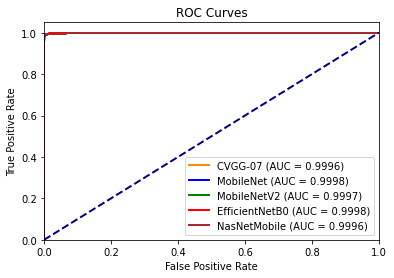

In [ ]:
plt.figure(6)
lw = 2
plt.plot(fpr_cvgg, tpr_cvgg, color='darkorange',
         lw=lw, label='CVGG-07 (AUC = %0.4f)' % auc_cvgg)
plt.plot(fpr_mn, tpr_mn, color='blue',
         lw=lw, label='MobileNet (AUC = %0.4f)' % auc_mn)
plt.plot(fpr_mn2, tpr_mn2, color='green',
         lw=lw, label='MobileNetV2 (AUC = %0.4f)' % auc_mn2)
plt.plot(fpr_en, tpr_en, color='red',
         lw=lw, label='EfficientNetB0 (AUC = %0.4f)' % auc_en)
plt.plot(fpr_nn, tpr_nn, color='brown',
         lw=lw, label='NasNetMobile (AUC = %0.4f)' % auc_nn)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="best")
plt.show()

In [ ]:
# plotting using plot-metric

!pip install plot-metric

import plot_metric
from plot_metric.functions import BinaryClassification

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

    WithMask       0.99      1.00      0.99       483
 WithoutMask       1.00      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



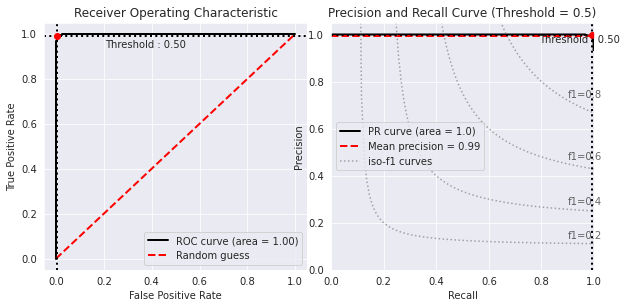

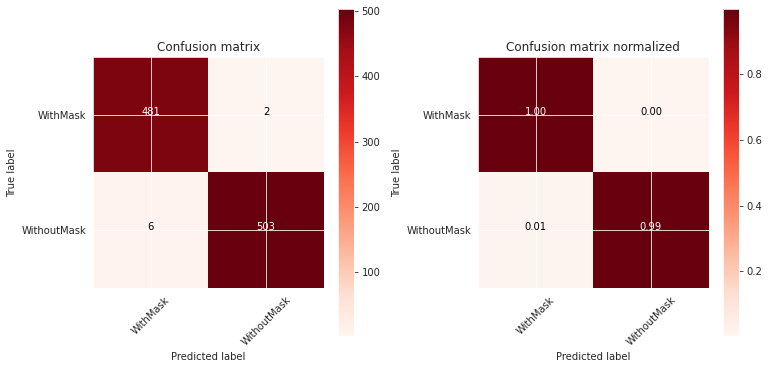

In [ ]:
bc = BinaryClassification(test_gen.classes, y_pred_CVGG, ["WithMask", "WithoutMask"])

# ROC
plt.figure(figsize = (15, 10))
plt.subplot2grid(shape = (2, 6), loc = (0, 0), colspan = 2)
bc.plot_roc_curve()

# Precission and Recall
plt.subplot2grid((2, 6), (0, 2), colspan = 2)
bc.plot_precision_recall_curve()

bc.print_report()

# plotting

plt.figure(figsize = (15,10))
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       483
 WithoutMask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



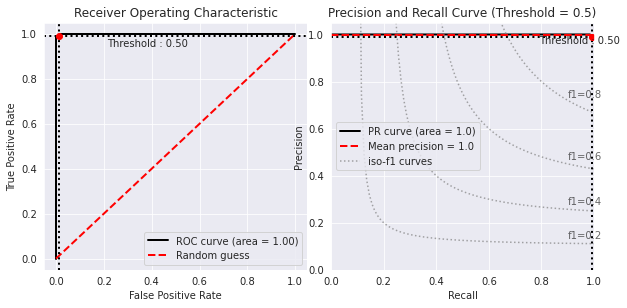

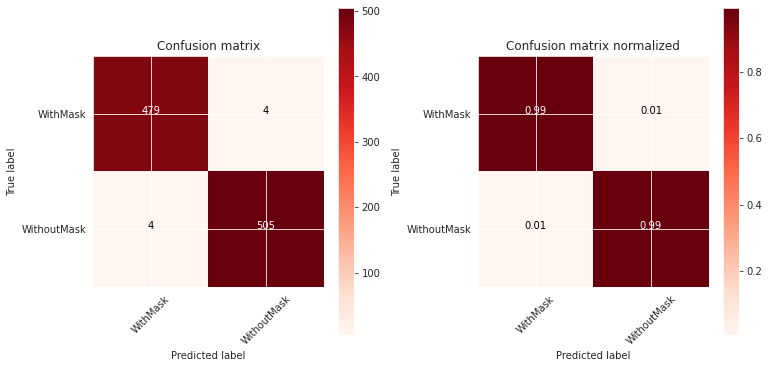

In [ ]:
bc1 = BinaryClassification(test_gen.classes, y_pred_mn, ["WithMask", "WithoutMask"])

# ROC
plt.figure(figsize = (15, 10))
plt.subplot2grid(shape = (2, 6), loc = (0, 0), colspan = 2)
bc1.plot_roc_curve()

# Precission and Recall
plt.subplot2grid((2, 6), (0, 2), colspan = 2)
bc1.plot_precision_recall_curve()

bc1.print_report()

# plotting

plt.figure(figsize = (15,10))
plt.subplot2grid((2,6), (1,1), colspan=2)
bc1.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc1.plot_confusion_matrix(normalize=True)
plt.show()

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

    WithMask       0.99      1.00      1.00       483
 WithoutMask       1.00      0.99      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



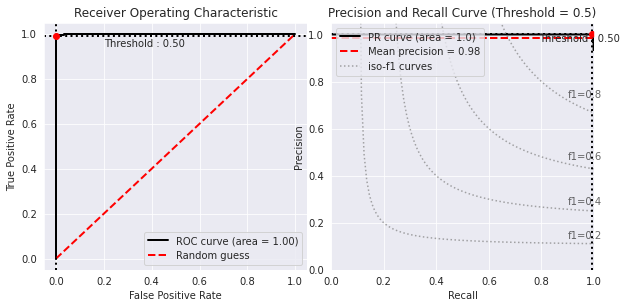

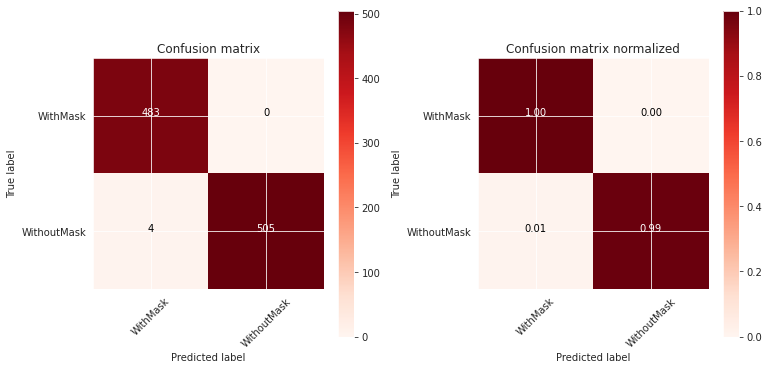

In [ ]:
bc2 = BinaryClassification(test_gen.classes, y_pred_mn2, ["WithMask", "WithoutMask"])

# ROC
plt.figure(figsize = (15, 10))
plt.subplot2grid(shape = (2, 6), loc = (0, 0), colspan = 2)
bc2.plot_roc_curve()

# Precission and Recall
plt.subplot2grid((2, 6), (0, 2), colspan = 2)
bc2.plot_precision_recall_curve()

bc2.print_report()

# plotting

plt.figure(figsize = (15,10))
plt.subplot2grid((2,6), (1,1), colspan=2)
bc2.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc2.plot_confusion_matrix(normalize=True)
plt.show()

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       483
 WithoutMask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



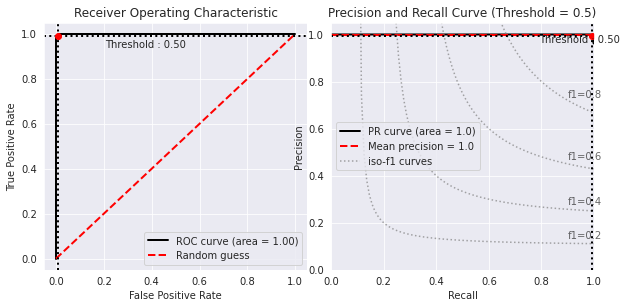

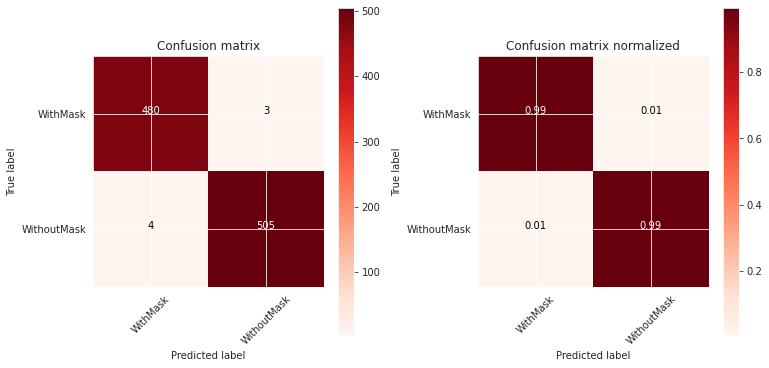

In [ ]:
bc3 = BinaryClassification(test_gen.classes, y_pred_en, ["WithMask", "WithoutMask"])

# ROC
plt.figure(figsize = (15, 10))
plt.subplot2grid(shape = (2, 6), loc = (0, 0), colspan = 2)
bc3.plot_roc_curve()

# Precission and Recall
plt.subplot2grid((2, 6), (0, 2), colspan = 2)
bc3.plot_precision_recall_curve()

bc3.print_report()

# plotting

plt.figure(figsize = (15,10))
plt.subplot2grid((2,6), (1,1), colspan=2)
bc3.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc3.plot_confusion_matrix(normalize=True)
plt.show()

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       483
 WithoutMask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



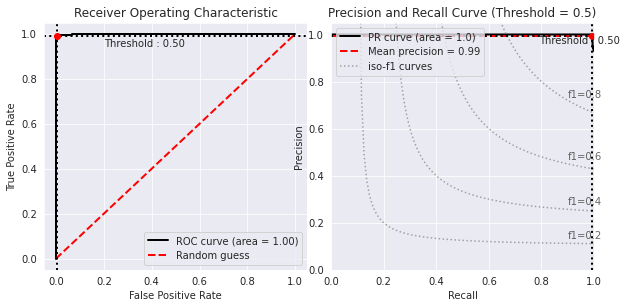

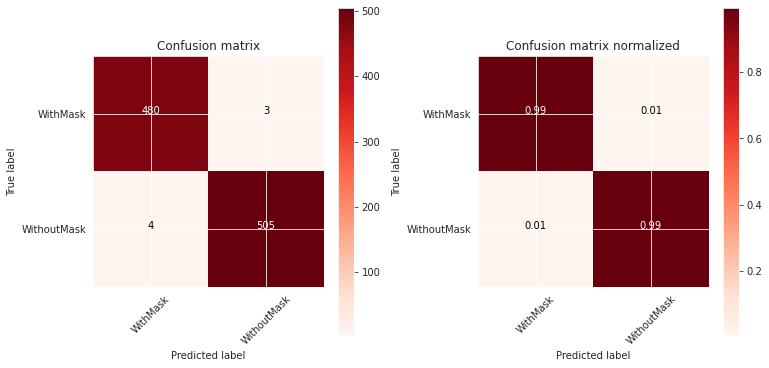

In [ ]:
bc4 = BinaryClassification(test_gen.classes, y_pred_nn, ["WithMask", "WithoutMask"])

# ROC
plt.figure(figsize = (15, 10))
plt.subplot2grid(shape = (2, 6), loc = (0, 0), colspan = 2)
bc4.plot_roc_curve()

# Precission and Recall
plt.subplot2grid((2, 6), (0, 2), colspan = 2)
bc4.plot_precision_recall_curve()

bc4.print_report()

# plotting

plt.figure(figsize = (15,10))
plt.subplot2grid((2,6), (1,1), colspan=2)
bc4.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc4.plot_confusion_matrix(normalize=True)
plt.show()